<a href="https://colab.research.google.com/github/Foluwa/mscthesis/blob/main/MSCTHESIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!curl ipinfo.io

{
  "ip": "34.125.143.198",
  "hostname": "198.143.125.34.bc.googleusercontent.com",
  "city": "Las Vegas",
  "region": "Nevada",
  "country": "US",
  "loc": "36.1750,-115.1372",
  "org": "AS396982 Google LLC",
  "postal": "89111",
  "timezone": "America/Los_Angeles",
  "readme": "https://ipinfo.io/missingauth"
}

In [ ]:
# Redirect stdout and stderr
# import sys
# import os
# sys.stdout = open(os.devnull, 'w')
# sys.stderr = open(os.devnull, 'w')
!pip install yfinance pmdarima statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.2 MB/s eta 0:00:00


In [ ]:
# Standard library imports
import itertools
from itertools import product
import math
import os
import sys
import warnings
from datetime import datetime, timedelta

# Third-party library imports
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import requests
import seaborn as sns
import yfinance as yf
from bs4 import BeautifulSoup
from pandas_datareader import data as pdr
from pmdarima import auto_arima
from plotly.subplots import make_subplots
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm

import tensorflow as tf

# Keras imports
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

# Pandas plotting
from pandas.plotting import lag_plot

# Matplotlib configuration
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
plt.style.use('seaborn')
# Use a consistent style
# plt.style.use('seaborn-darkgrid')
warnings.filterwarnings('ignore')

In [ ]:
# url = 'https://raw.githubusercontent.com/Foluwa/mscthesis/main/datasets/SPX_v1.csv'
# df = pd.read_csv(url)

# Download Data and tickers

In [ ]:
# Download data
TICKER = "TSLA"
gs = yf.download(TICKER, start="2011-01-01", end="2021-01-01")

# df_tsla = yf.download(TICKER, start="2011-01-01", end="2021-01-01")

df_tsla = pd.read_csv(f"{TICKER}.csv")
# df_tsla = gs

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df_tsla.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


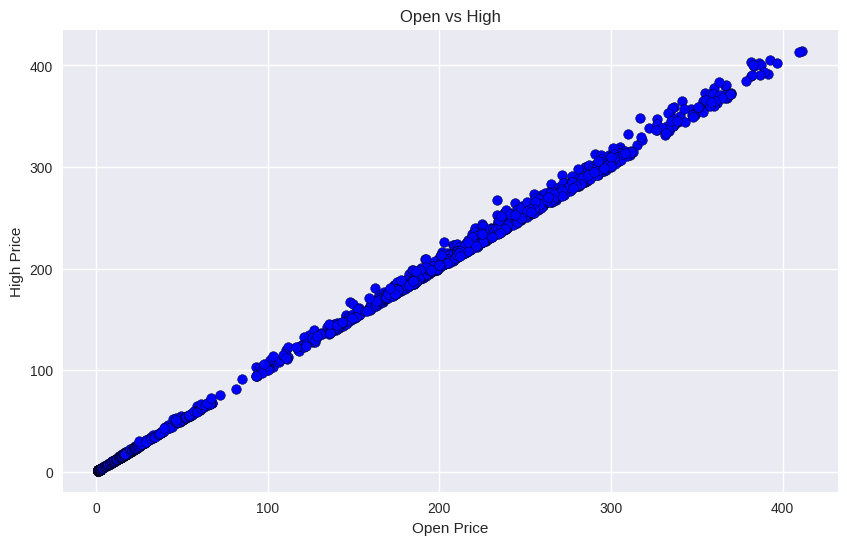

done


In [ ]:
def plot_open_vs_high(df):
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Open'], df['High'], color='blue', edgecolor='black')
    plt.title('Open vs High')
    plt.xlabel('Open Price')
    plt.ylabel('High Price')
    plt.grid(True)
    plt.show()
    print('done')

plot_open_vs_high(df_tsla)

# Feature Engineering

In [ ]:
df_tsla.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3544.000000,3544.000000,3544.000000,3544.000000,3544.000000,3.544000e+03
mean,75.461458,77.115431,73.702271,75.445748,75.445748,9.699568e+07
std,102.511170,104.788841,100.035797,102.441247,102.441247,7.867922e+07
min,1.076000,1.108667,0.998667,1.053333,1.053333,1.777500e+06
25%,11.516667,11.859000,11.212500,11.562500,11.562500,4.766288e+07
50%,17.463333,17.688333,17.097334,17.454333,17.454333,8.247975e+07
75%,161.144997,165.218327,157.722497,161.269997,161.269997,1.229246e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


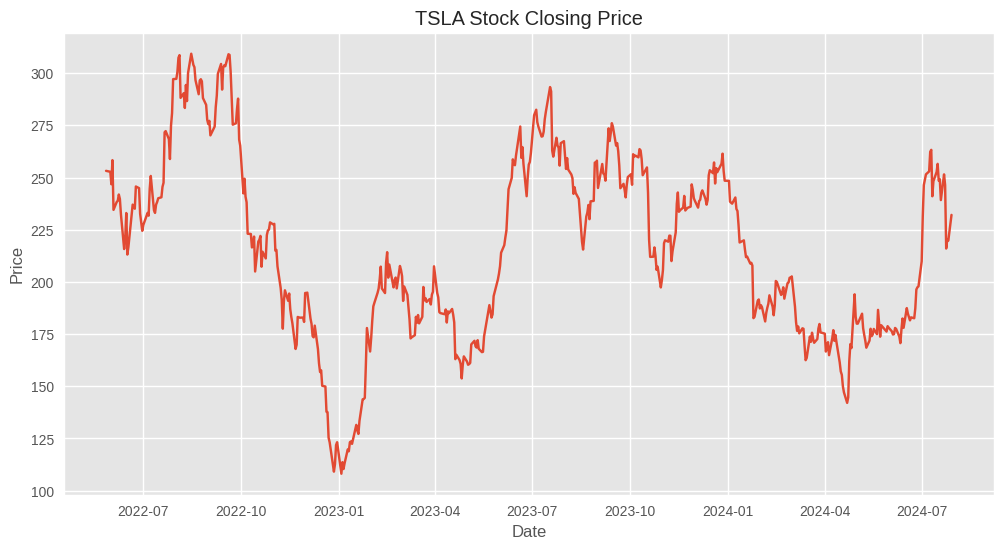

In [ ]:
# Plot the closing price
plt.figure(figsize=(12, 6))
# plt.plot(df_tsla.index, gs['Close'])
plt.plot(df_tsla['Close'][3000:])
plt.title('TSLA Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Text(0.5, 1.0, 'Relative Strength Index (RSI)')

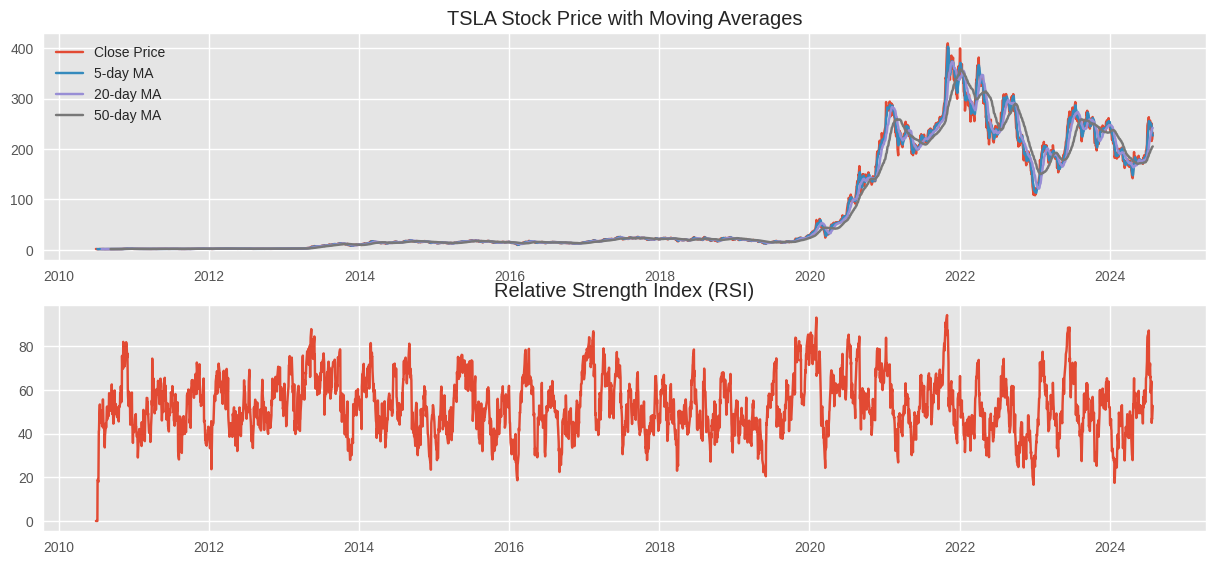

In [ ]:
# 1. Moving Averages
df_tsla['MA5'] = df_tsla['Close'].rolling(window=5).mean()
df_tsla['MA20'] = df_tsla['Close'].rolling(window=20).mean()
df_tsla['MA50'] = df_tsla['Close'].rolling(window=50).mean()

# 2. Relative Strength Index (RSI)
def compute_rsi(data, window=14):
    diff = data.diff()
    up = diff.clip(lower=0)
    down = -1 * diff.clip(upper=0)
    ema_up = up.ewm(com=window - 1, adjust=False).mean()
    ema_down = down.ewm(com=window - 1, adjust=False).mean()
    rs = ema_up / ema_down
    return 100 - (100 / (1 + rs))

df_tsla['RSI'] = compute_rsi(df_tsla['Close'])

# 3. Bollinger Bands
df_tsla['BB_middle'] = df_tsla['Close'].rolling(window=20).mean()
df_tsla['BB_upper'] = df_tsla['BB_middle'] + 2 * df_tsla['Close'].rolling(window=20).std()
df_tsla['BB_lower'] = df_tsla['BB_middle'] - 2 * df_tsla['Close'].rolling(window=20).std()

# 4. Trading Volume Features
df_tsla['Volume_MA5'] = df_tsla['Volume'].rolling(window=5).mean()
df_tsla['Volume_Ratio'] = df_tsla['Volume'] / df_tsla['Volume_MA5']

# 5. Price Momentum
df_tsla['Price_Momentum'] = df_tsla['Close'] - df_tsla['Close'].shift(5)

# 6. Date-based Features
df_tsla['Day_of_Week'] = df_tsla.index.dayofweek
df_tsla['Month'] = df_tsla.index.month
df_tsla['Quarter'] = df_tsla.index.quarter

# Plot some of the engineered features
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(df_tsla.index, df_tsla['Close'], label='Close Price')
plt.plot(df_tsla.index, df_tsla['MA5'], label='5-day MA')
plt.plot(df_tsla.index, df_tsla['MA20'], label='20-day MA')
plt.plot(df_tsla.index, df_tsla['MA50'], label='50-day MA')
plt.title('TSLA Stock Price with Moving Averages')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df_tsla.index, df_tsla['RSI'], label='RSI')
plt.title('Relative Strength Index (RSI)')

# Exploratory Data Analysis

In [ ]:
df_tsla.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [ ]:
df_tsla.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [ ]:
import plotly.express as px
fig = px.line(df_tsla, x= df_tsla.index , y= 'Close')
# fig.update_xaxes(rangeslider_visible=True)
fig.show()

# **AutoCorrelation and Partial Correlation**


>* Autocorrelation is simply the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.

> * Partial Autocorrelation also conveys similar information but it conveys the pure correlation of a series and its lag, excluding the correlation contributions from the intermediate lags.

### ***ACF***

Autocorrelation, sometimes known as serial correlation, is the correlation of a time series with a delayed copy of itself as a function of delay. That is, it measures the similarity between observations as a function of the time lag between them. The autocorrelation function can be used basically to detect non-randomness in data and identify cyclical patterns if present.

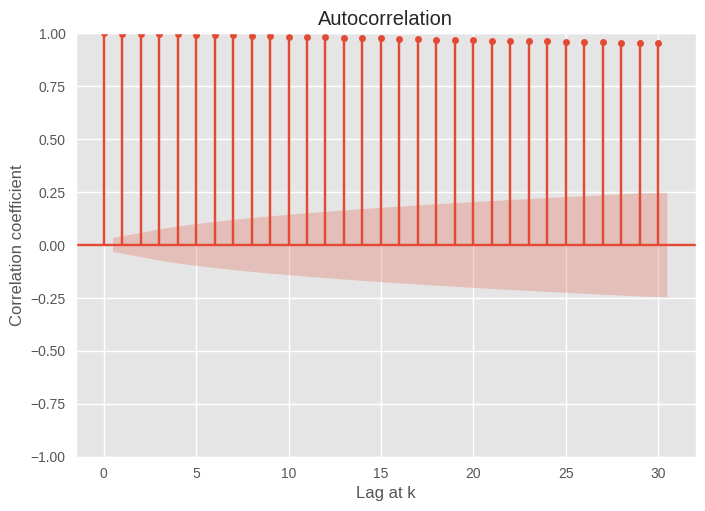

In [ ]:
# from datetime import datetime
# from statsmodels.tsa.stattools import acf , pacf
# from statsmodels.graphics.tsaplots import plot_acf
# plt.style.use('ggplot')
# plot_acf(df_tsla, lags=30)
# plt.ylabel("Correlation coefficient")
# plt.xlabel('Lag at k')
# plt.title('Autocorrelation')

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Assuming df_tsla is your DataFrame and 'Close' is the column with numerical data
numerical_data = df_tsla['Close']

plt.style.use('ggplot')
plot_acf(numerical_data, lags=30)
plt.ylabel("Correlation coefficient")
plt.xlabel('Lag at k')
plt.show()


### ***PACF***

The partial autocorrelation function of lag (k) of a series is the coefficient of that lag in the autoregression equation of Y. The autoregressive equation of Y is nothing but the linear regression of Y with its own lags as predictors.

For example, if Y_t is the current series and Y_t-1 is the lag 1 of Y, then the partial autocorrelation of lag 3 (Y_t-3) is the coefficient α3 of Y_t-3 in the following equation:

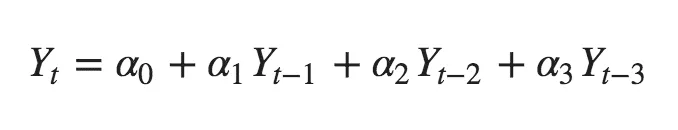

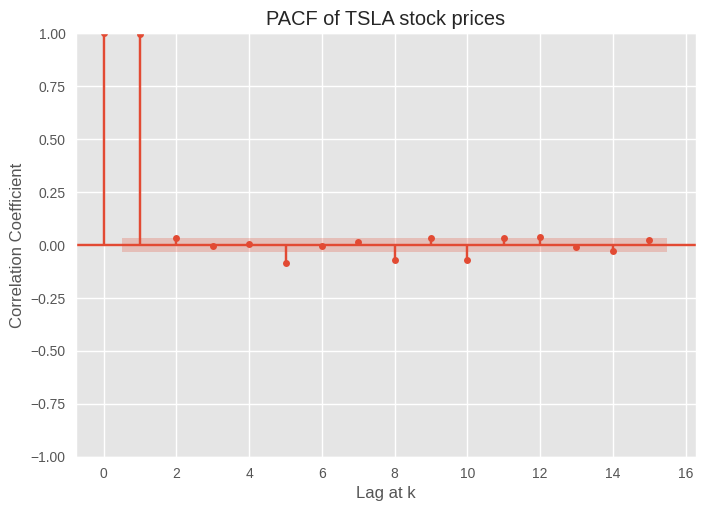

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
numerical_data = df_tsla['Close']

plt.style.use('ggplot')
plot_pacf(numerical_data, lags=15)
plt.title("PACF of TSLA stock prices")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show()


## **Stationarity**:
Most of the time series are non-stationary either it gives an upward or downward trend or seasonal effect. checking the stationarity is the most important thing that we should handle if we want to make a good prediction of such time serie.

#### ***Graphical Analysis***:
**1**- **Lag Plot**:
The stationarity can be checked by looking at Lag plot. A lag plot is used to checks whether the time series data is random or not, and if the data is correlated with themselves. Random data should not have any identifiable patterns, such as linear.

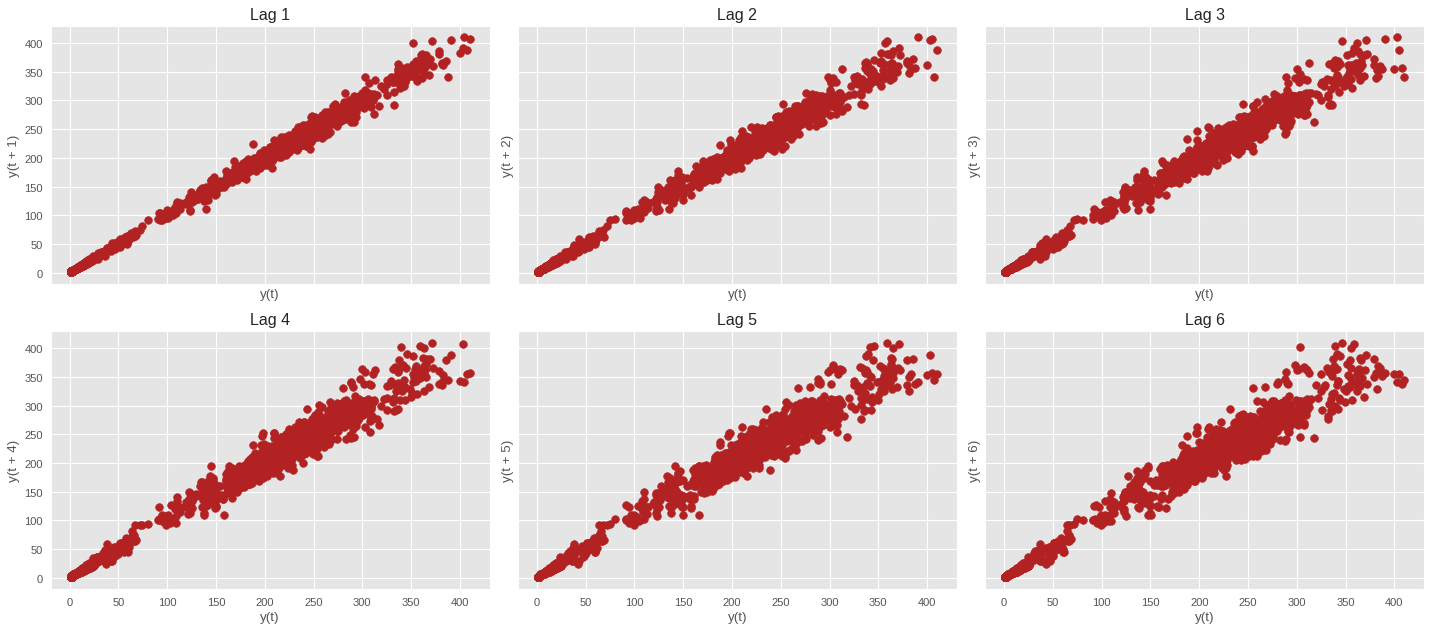

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot

# Assuming df_tsla is your DataFrame and 'Close' is the column with numerical data
numerical_data = df_tsla['Close']

fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True, dpi=80)
for i, ax in enumerate(axes.flatten()[:6]):
    lag_plot(numerical_data, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

plt.tight_layout()
plt.show()


**2**- **Rolling Statistic**:

we can check for stationarity by looking at how rolling average and rolling standard deviation behave in time.

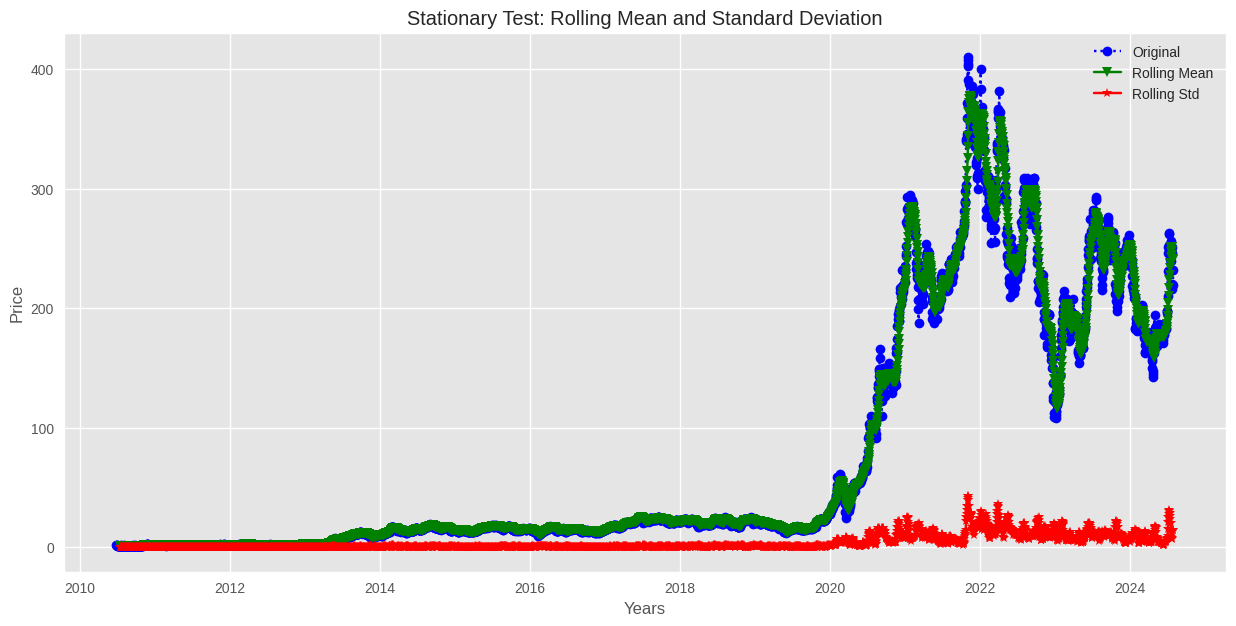

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'Date' column to datetime
df_tsla['Date'] = pd.to_datetime(df_tsla['Date'])

# Set 'Date' column as the index
df_tsla.set_index('Date', inplace=True)

# Ensure 'Close' is numeric
numerical_data = df_tsla['Close']

# Get rolling statistics for window = 12 i.e. yearly statistics
rolling_mean = numerical_data.rolling(window=12).mean()
rolling_std = numerical_data.rolling(window=12).std()

# Plot rolling statistics
plt.figure(figsize=(15, 7))
plt.xlabel('Years')
plt.ylabel('Price')
plt.title('Stationary Test: Rolling Mean and Standard Deviation')
plt.plot(df_tsla.index, numerical_data, 'b:', marker='o', label='Original')
plt.plot(df_tsla.index, rolling_mean, 'g-', marker='v', label='Rolling Mean')
plt.plot(df_tsla.index, rolling_std, 'r-', marker='*', label='Rolling Std')
plt.legend()
plt.show()


### ***Augmented Dickey Fuller test (ADF Test)***:
Augmented Dickey Fuller test or (ADF Test) is the most commonly used test to detect stationarity. Here, we assume that the null hypothesis is the time series possesses a unit root and is non-stationary. Then, we collect evidence to support or reject the null hypothesis. So, if we find that the p-value in ADF test is less than the significance level (0.05), we reject the null hypothesis.

ADF tests the null hypothesis that a unit root is present in time series sample. ADF statistic is a negative number and more negative it is the stronger the rejection of the hypothesis that there is a unit root.

> * Null Hypotehsis (H0): If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
> * Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary.
> * p-value > 0.05: Accept H0, the data has a unit root and is non-stationary
> * p-value ≤ 0.05: Reject H0. the data does not have a unit root and is stationary

> * Test statistics: More negative this value more likely we have stationary series. Also, this value should be smaller than critical values(1%, 5%, 10%). For e.g. If test statistic is smaller than the 5% critical values, then we can say with 95% confidence that this is a stationary series.

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# def stationarity_test(time_series):
#     df_test = adfuller(time_series)

#     print('{:25s} {:.6f}'.format("\033[1m ADF Statistic ", df_test[0]))
#     print('{:25s} {:.6f}\n'.format("\033[1m p-value ", df_test[1]))

#     if df_test[0] > df_test[4]["5%"]:
#         print("\033[36m\033[1mFailed to Reject Ho - Time Series is Non-Stationary\n")
#     else:
#         print("\033[36m\033[1mReject Ho - Time Series is Stationary\n")

#     a = pd.DataFrame([df_test[4]], index=['Critical Values'])
#     return a

def stationarity_test(time_series):
    # Ensure input is a Series and has no missing values
    time_series = time_series.dropna()

    df_test = adfuller(time_series)

    print('{:25s} {:.6f}'.format("\033[1m ADF Statistic ", df_test[0]))
    print('{:25s} {:.6f}'.format("\033[1m p-value ", df_test[1]))

    if df_test[0] > df_test[4]["5%"]:
        print("\033[36m\033[1mFailed to Reject Ho - Time Series is Non-Stationary\n")
    else:
        print("\033[36m\033[1mReject Ho - Time Series is Stationary\n")

    a = pd.DataFrame([df_test[4]], index=['Critical Values'])
    return a


In [ ]:
# Lets test the stationarity
stationarity_test(df_tsla['Close'])

 ADF Statistic        -1.103908
 p-value              0.713511
Failed to Reject Ho - Time Series is Non-Stationary



,1%,5%,10%
Critical Values,-3.432212,-2.862363,-2.567208


**As** we see the test statistic is way above any critica values and the p-value also way above 0.05. then the time serie has an unit root and is non-stationary.

There is many sort of transformations to make the time series stationary for make it able to be modeled.

### ***Differencing***:
To transform the series using 'Differencing' we will use the diff() method of pandas.

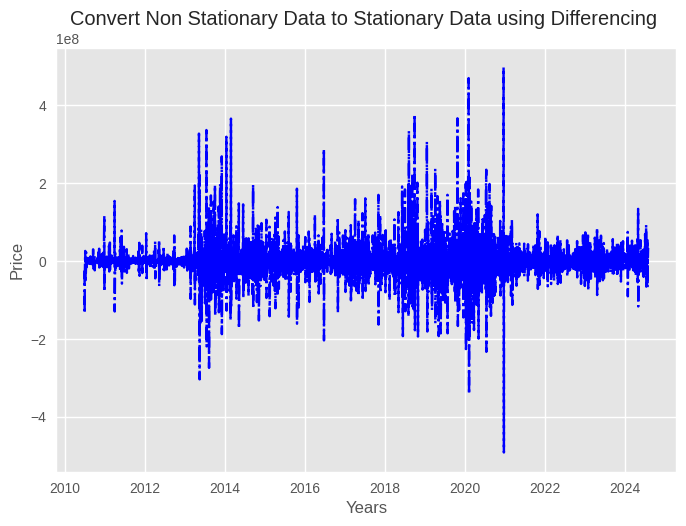

In [ ]:
df_tsla_stock = df_tsla.diff(1).bfill() # First order differencing
plt.xlabel('Years')
plt.ylabel('Price')
plt.title('Convert Non Stationary Data to Stationary Data using Differencing ')
plt.plot(df_tsla_stock, 'b-.')

In [ ]:
# stationarity_test(df_tsla_stock)

In [ ]:
def plot_charts(df):

    # Create a 2x2 grid for subplots
    fig, axs = plt.subplots(2, 2, figsize=(30, 15))

    # Plot the distribution of the 'Close' prices
    sns.histplot(df['Close'], bins=50, kde=True, color='royalblue', ax=axs[0, 0])
    axs[0, 0].set_title('Distribution of Close Prices')
    axs[0, 0].set_xlabel('Close Price')
    axs[0, 0].set_ylabel('Frequency')

    # Plot the time series of the 'Close' prices
    df['Close'].plot(ax=axs[0, 1], color='royalblue', legend=True)
    axs[0, 1].set_title('Time Series of Close Prices')
    axs[0, 1].set_xlabel('Date')
    axs[0, 1].set_ylabel('Close Price')
    axs[0, 1].legend(['Close'], loc='upper left')

    # Plot the correlation matrix
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, ax=axs[1, 0])
    axs[1, 0].set_title('Correlation Matrix')

    # Plot the histogram of closing prices with date
    df.reset_index()['Date'].map(lambda x: x.year).hist(bins=50, color='royalblue', edgecolor='black', ax=axs[1, 1])
    axs[1, 1].set_title('Histogram of Closing Prices with Date')
    axs[1, 1].set_xlabel('Date')
    axs[1, 1].set_ylabel('Frequency')
    axs[1, 1].grid(True)

    # Adjust layout
    plt.tight_layout()
    return plt.show()

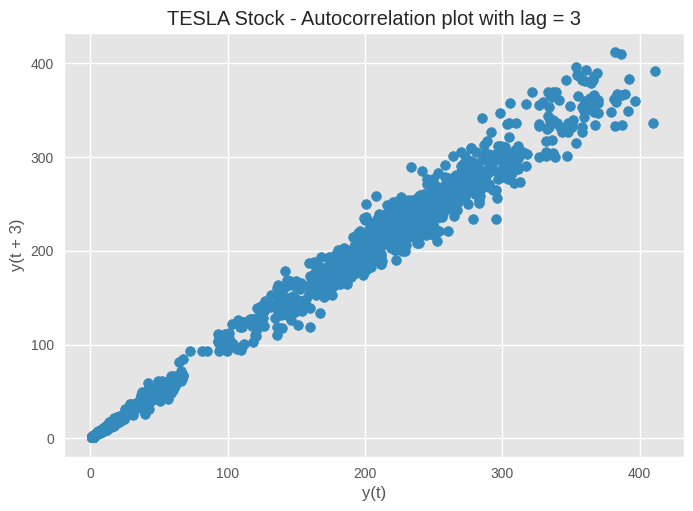

In [ ]:
plt.figure()
lag_plot(df_tsla['Open'], lag=3)
plt.title('TESLA Stock - Autocorrelation plot with lag = 3')
plt.show()

### Augmented Dickey–Fuller test (ADF)

In [ ]:
# from pmdarima.arima import ADFTest

# # Ensure 'Date' is in datetime format and set it as index if necessary
# df_tsla['Date'] = pd.to_datetime(df_tsla['Date'])
# df_tsla.set_index('Date', inplace=True)

# # Extract the numeric time series (e.g., 'Close' column)
# numeric_series = df_tsla['Close']

# # Perform ADF test
# adf_test = ADFTest(alpha=0.05)
# adf_test.should_diff(numeric_series)

# Autoregressive Integrated Moving Average (ARIMA)


#### First ARIMA

In [ ]:
covid_data = df_tsla
# Set the 'Date' column as the index
# covid_data.set_index('Date', inplace=True)

# Split the data into training and testing sets
train_size = int(len(covid_data) * 0.8)
train, test = covid_data[:train_size], covid_data[train_size:]

# Build and train the ARIMA model
model = ARIMA(train['Close'], order=(0, 1, 0))
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

# Forecast the closing prices
forecast = model_fit.forecast(steps=len(test))

# Evaluate the model
mse = mean_squared_error(test['Close'], forecast)
print('Mean Squared Error:', mse)

# Prepare the data for plotting
train['Type'] = 'Train'
test['Type'] = 'Test'
forecast_df = pd.DataFrame({'Date': test.index, 'Close': forecast, 'Type': 'Forecast'})

# Concatenate the data for plotting
plot_data = pd.concat([train, test, forecast_df.set_index('Date')])

# Reset index for Plotly
plot_data.reset_index(inplace=True)

# Plot the actual vs forecasted values using Plotly
fig = px.line(plot_data, x='Date', y='Close', color='Type',
              title='ARIMA Model Forecast of Closing Prices During COVID-19 Period')

fig.show()


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2835
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -6691.201
Date:                Wed, 31 Jul 2024   AIC                          13384.403
Time:                        04:23:07   BIC                          13390.352
Sample:                             0   HQIC                         13386.549
                               - 2835                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         6.5811      0.038    173.704      0.000       6.507       6.655
Ljung-Box (L1) (Q):                  13.54   Jarque-Bera (JB):            194756.49
Prob(Q):                              0.00   Pr

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import plotly.express as px

def forecast_stock_data(df, start_date='2020-01-01', end_date='2021-12-31', arima_order=(0, 1, 0)):
    """
    Forecasts the closing prices using ARIMA model for a given time period and plots the results.

    Parameters:
    df (pd.DataFrame): DataFrame containing the time series data with a 'Date' and 'Close' column.
    start_date (str): Start date for filtering the data.
    end_date (str): End date for filtering the data.
    arima_order (tuple): The order of the ARIMA model (p, d, q).

    Returns:
    None
    """
    # Select the data for the specified time period
    covid_data = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

    # Set the 'Date' column as the index
    # covid_data.set_index('Date', inplace=True)

    # Split the data into training and testing sets
    train_size = int(len(covid_data) * 0.8)
    train, test = covid_data[:train_size], covid_data[train_size:]

    # Build and train the ARIMA model
    model = ARIMA(train['Close'], order=arima_order)
    model_fit = model.fit()

    # Print the model summary
    print(model_fit.summary())

    # Forecast the closing prices
    forecast = model_fit.forecast(steps=len(test))

    # Evaluate the model
    mse = mean_squared_error(test['Close'], forecast)
    print('Mean Squared Error:', mse)

    # Prepare the data for plotting
    train['Type'] = 'Train'
    test['Type'] = 'Test'
    forecast_df = pd.DataFrame({'Date': test.index, 'Close': forecast, 'Type': 'Forecast'})

    # Concatenate the data for plotting
    plot_data = pd.concat([train, test, forecast_df.set_index('Date')])

    # Reset index for Plotly
    plot_data.reset_index(inplace=True)

    # Plot the actual vs forecasted values using Plotly
    fig = px.line(plot_data, x='Date', y='Close', color='Type',
                  title='ARIMA Model Forecast of Closing Prices During Specified Period')

    return fig.show()

# Example usage:
# df = pd.read_csv('your_data.csv')  # Replace with your DataFrame loading code
# forecast_covid_data(df)


In [ ]:
# df_tsla.set_index('Date', inplace=True)
# df_tsla.head()

In [ ]:
df_tsla1 = pd.read_csv('TSLA.csv')
forecast_stock_data(df_tsla1, start_date='2020-01-01', end_date='2021-12-31', arima_order=(0, 1, 0))

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  404
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1331.525
Date:                Wed, 31 Jul 2024   AIC                           2665.049
Time:                        04:23:08   BIC                           2669.048
Sample:                             0   HQIC                          2666.633
                                - 404                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        43.3881      1.766     24.575      0.000      39.928      46.848
Ljung-Box (L1) (Q):                   2.48   Jarque-Bera (JB):               270.71
Prob(Q):                              0.12   Pr

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3544
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -10543.333
Date:                Wed, 31 Jul 2024   AIC                          21108.665
Time:                        04:23:32   BIC                          21176.565
Sample:                             0   HQIC                         21132.883
                               - 3544                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6379     33.968     -0.019      0.985     -67.214      65.938
ar.L2         -0.0949     19.135     -0.005      0.996     -37.598      37.408
ar.L3          0.7168      1.847      0.388      0.6

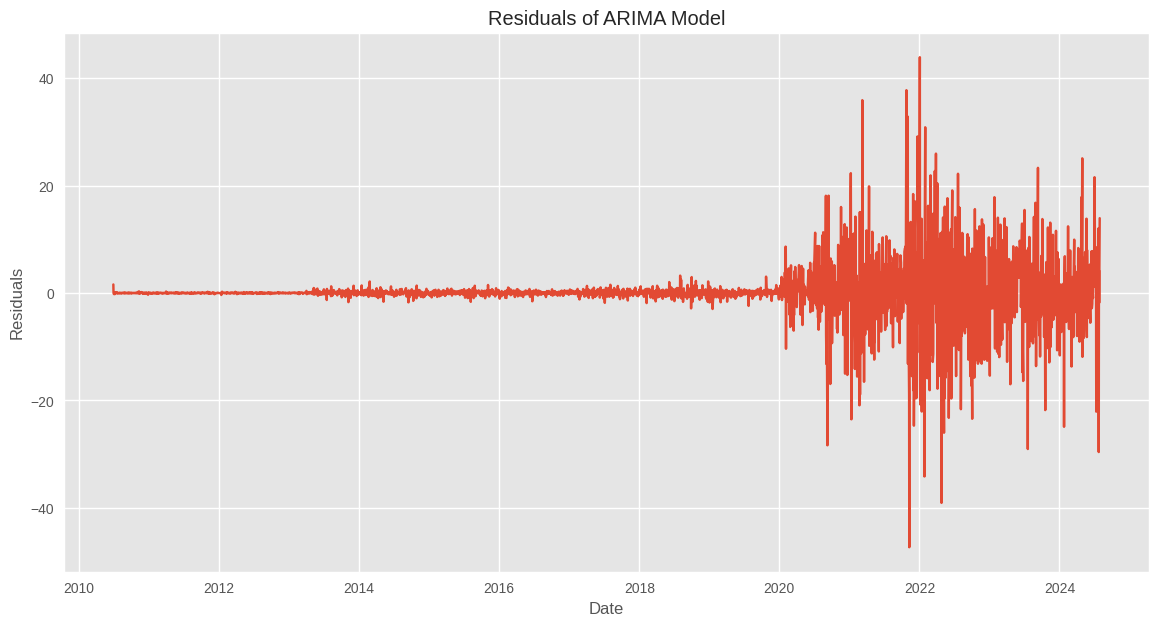

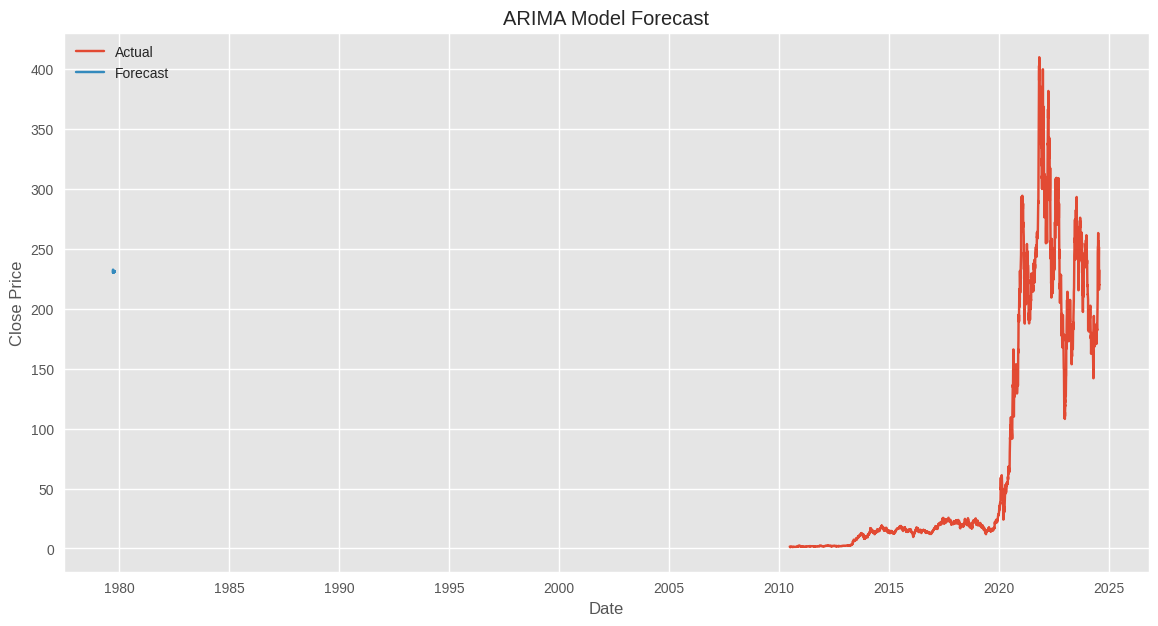

In [ ]:
# Define the ARIMA model (p, d, q) parameters
p = 5  # autoregressive order
q = 5  # moving average order
d = 1  # differencing order

# Fit the ARIMA model
model = ARIMA(df_tsla['Close'], order=(p, d, q))
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

# Plot the residuals
residuals = model_fit.resid
plt.figure(figsize=(14, 7))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

# Plot the forecast
forecast = model_fit.forecast(steps=30)
plt.figure(figsize=(14, 7))
plt.plot(df_tsla['Close'], label='Actual')
plt.plot(forecast, label='Forecast')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [ ]:
# def forecast_stock_best_order(df, start_date='2020-01-01', end_date='2021-12-31', p_range=range(1, 7), d_range=range(1, 2), q_range=range(1, 7)):
def forecast_stock_best_order(df, start_date='2020-01-01', end_date='2021-12-31', p_range=range(1, 7), d_range=range(1, 2), q_range=range(1, 7)):
    """
    Forecasts the closing prices using the best ARIMA model based on MSE from a range of (p, d, q) values.

    Parameters:
    df (pd.DataFrame): DataFrame containing the time series data with a 'Date' and 'Close' column.
    start_date (str): Start date for filtering the data.
    end_date (str): End date for filtering the data.
    p_range (range): Range of p values to test.
    d_range (range): Range of d values to test.
    q_range (range): Range of q values to test.

    Returns:
    None
    """
    # Select the data for the specified time period
    covid_data = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

    # Set the 'Date' column as the index
    covid_data.set_index('Date', inplace=True)

    # Split the data into training and testing sets
    train_size = int(len(covid_data) * 0.8)
    train, test = covid_data[:train_size], covid_data[train_size:]

    best_mse = float('inf')
    best_order = None
    best_model_fit = None

    # Iterate over all possible combinations of (p, d, q)
    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    # Build and train the ARIMA model
                    model = ARIMA(train['Close'], order=(p, d, q))
                    model_fit = model.fit()

                    # Forecast the closing prices
                    forecast = model_fit.forecast(steps=len(test))

                    # Evaluate the model
                    mse = mean_squared_error(test['Close'], forecast)

                    # Check if this model is better
                    if mse < best_mse:
                        best_mse = mse
                        best_order = (p, d, q)
                        best_model_fit = model_fit

                except Exception as e:
                    print(f"Error with order {(p, d, q)}: {e}")
                    continue

    if best_model_fit is None:
        print("No suitable ARIMA model found.")
        return

    # Print details of the best model
    print(f"Best ARIMA Order: {best_order}")
    print(f"Best Mean Squared Error: {best_mse}")
    print("Best Model Summary:")
    print(best_model_fit.summary())

    # Forecast using the best model
    forecast = best_model_fit.forecast(steps=len(test))

    # Prepare the data for plotting
    train['Type'] = 'Train'
    test['Type'] = 'Test'
    forecast_df = pd.DataFrame({'Date': test.index, 'Close': forecast, 'Type': 'Forecast'})

    # Concatenate the data for plotting
    plot_data = pd.concat([train, test, forecast_df.set_index('Date')])

    # Reset index for Plotly
    plot_data.reset_index(inplace=True)

    # Plot the actual vs forecasted values using Plotly
    fig = px.line(plot_data, x='Date', y='Close', color='Type',
                  title='ARIMA Model Forecast of Closing Prices During Specified Period')

    # Add the model details to the plot
    if not forecast_df.empty:
        last_date = forecast_df['Date'].iloc[-1]
        last_forecast = forecast_df['Close'].iloc[-1]
        fig.add_annotation(
            x=last_date, y=last_forecast,
            text=f"Best Model: ARIMA{best_order}<br>MSE: {best_mse:.4f}",
            showarrow=True,
            arrowhead=2
        )

    fig.show()

In [ ]:

# forecast_stock_best_order(df_tsla)
forecast_stock_best_order(df_tsla1)


Best ARIMA Order: (6, 1, 5)
Best Mean Squared Error: 6514.020230548643
Best Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  404
Model:                 ARIMA(6, 1, 5)   Log Likelihood               -1320.443
Date:                Wed, 31 Jul 2024   AIC                           2664.885
Time:                        04:24:35   BIC                           2712.873
Sample:                             0   HQIC                          2683.883
                                - 404                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6157      0.234      2.633      0.008       0.157       1.074
ar.L2          0.3290      0.245      1.

#### Second ARIMA

https://medium.com/shikhars-data-science-projects/predicting-stock-prices-using-arima-fourier-transformation-and-deep-learning-e5fb4f693c85#:~:text=ARIMA%20is%20a%20statistical%20model,prices%20based%20on%20identified%20parameters


In `arima_forecast` function, the ARIMA model being used is a general ARIMA (AutoRegressive Integrated Moving Average) model. The specifics of the model, such as its order and type, are determined by the parameters passed to it. Let's break down the elements:

### Key Components in the Function:

1. **`ARIMA(self.history, order=self.model_order)`**:
   - **`self.history`**: This is the time series data on which the ARIMA model is being fitted.
   - **`order=self.model_order`**: This specifies the order of the ARIMA model. The `order` parameter is a tuple `(p, d, q)`:
     - **`p`**: The number of lag observations included in the model (the number of autoregressive terms).
     - **`d`**: The number of times that the raw observations are differenced (the degree of differencing).
     - **`q`**: The size of the moving average window (the number of lagged forecast errors in the prediction equation).

2. **`model.fit()`**: Fits the ARIMA model to the provided data.

3. **`output = model_fit.forecast()`**: Produces forecasts based on the fitted model.

4. **`yhat = output[0]`**: Extracts the forecasted value from the output.

### What Category of ARIMA Model Is This?

- **Category**: The model is a basic ARIMA model, where the type of ARIMA model is defined by the `(p, d, q)` parameters you provide. In general terms:
  - If `p = 0`, `d = 0`, and `q = 0`, it's a very simple model with no autoregressive or moving average terms and no differencing.
  - If `p > 0`, `d = 0`, and `q = 0`, it becomes an Autoregressive (AR) model.
  - If `p = 0`, `d = 0`, and `q > 0`, it becomes a Moving Average (MA) model.
  - If `p > 0`, `d > 0`, and `q > 0`, it represents a general ARIMA model with both autoregressive, moving average terms, and differencing.

The `arima_forecast` function is designed to fit and forecast using an ARIMA model. The exact nature of the ARIMA model (whether it’s an AR model, MA model, or full ARIMA model) depends on the `self.model_order` parameter that you pass into the function. This parameter needs to be a tuple `(p, d, q)` which defines the specifics of the ARIMA model being used.

In [ ]:
class ARIMAModel:
    def __init__(self, ticker, start_date, end_date):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.model_order = (0, 1, 0)
        self.train = None
        self.test = None
        self.dataset_ex_df = None
        self.history = None
        self.predictions = []

    def download_data(self):
        gs = yf.download(self.ticker, start=self.start_date, end=self.end_date)
        self.dataset_ex_df = gs[['Close']].copy()
        self.dataset_ex_df.reset_index(inplace=True)
        self.dataset_ex_df['Date'] = pd.to_datetime(self.dataset_ex_df['Date'])
        self.dataset_ex_df.set_index('Date', inplace=True)

    def determine_arima_order(self):
        model = auto_arima(self.dataset_ex_df['Close'], seasonal=False, trace=True)
        self.model_order = model.order
        print(model.summary())

    def split_data(self, train_ratio=0.8):
        X = self.dataset_ex_df.values
        size = int(len(X) * train_ratio)
        self.train, self.test = X[:size], X[size:]
        self.history = [x for x in self.train]

    def arima_forecast(self):
        model = ARIMA(self.history, order=self.model_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        return yhat

    def walk_forward_validation(self):
        self.predictions = []
        print('TEST_RANGE: ', range(len(self.test)))
        for t in range(len(self.test)):
            print('T')
            yhat = self.arima_forecast()
            print('yhat: ', yhat)
            self.predictions.append(yhat)
            obs = self.test[t]
            print('obs: ', obs)
            self.history.append(obs)
            print('_______________________________________')

    def plot_results(self):
        size = len(self.train)
        plt.figure(figsize=(12, 6), dpi=100)
        plt.plot(self.dataset_ex_df.index[:size], self.train, color='blue', label='Training Data')
        plt.plot(self.dataset_ex_df.index[size:], self.test, color='green', label='Actual Data')
        plt.plot(self.dataset_ex_df.index[size:], self.predictions, color='red', linestyle='dashed', label='Forecasted Data')
        plt.title('ARIMA Predictions vs Actual Values')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

In [ ]:
arimal_model = ARIMAModel(ticker=TICKER, start_date="2020-01-01", end_date="2024-01-01")

In [ ]:
arimal_model.download_data()

[*********************100%%**********************]  1 of 1 completed


In [ ]:
arimal_model.determine_arima_order()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7175.036, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7168.729, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7169.771, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7169.796, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7167.387, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7171.049, Time=0.59 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.894 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1006
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3582.694
Date:                Wed, 31 Jul 2024   AIC                           7167.387
Time:                        04:24:37   BIC                           7172.300
Sample:                             0   HQIC                          7169.254
          

In [ ]:
arimal_model.split_data()

In [ ]:
arimal_model.walk_forward_validation()

TEST_RANGE:  range(0, 202)
T
yhat:  174.47999572753906
obs:  [183.25999451]
_______________________________________
T
yhat:  183.25999450683594
obs:  [180.44999695]
_______________________________________
T
yhat:  180.4499969482422
obs:  [184.13000488]
_______________________________________
T
yhat:  184.1300048828125
obs:  [180.13000488]
_______________________________________
T
yhat:  180.1300048828125
obs:  [183.25]
_______________________________________
T
yhat:  183.25
obs:  [197.58000183]
_______________________________________
T
yhat:  197.5800018310547
obs:  [191.1499939]
_______________________________________
T
yhat:  191.14999389648438
obs:  [192.22000122]
_______________________________________
T
yhat:  192.22000122070312
obs:  [190.41000366]
_______________________________________
T
yhat:  190.41000366210938
obs:  [191.80999756]
_______________________________________
T
yhat:  191.80999755859375
obs:  [189.19000244]
_______________________________________
T
yhat:  189.1900

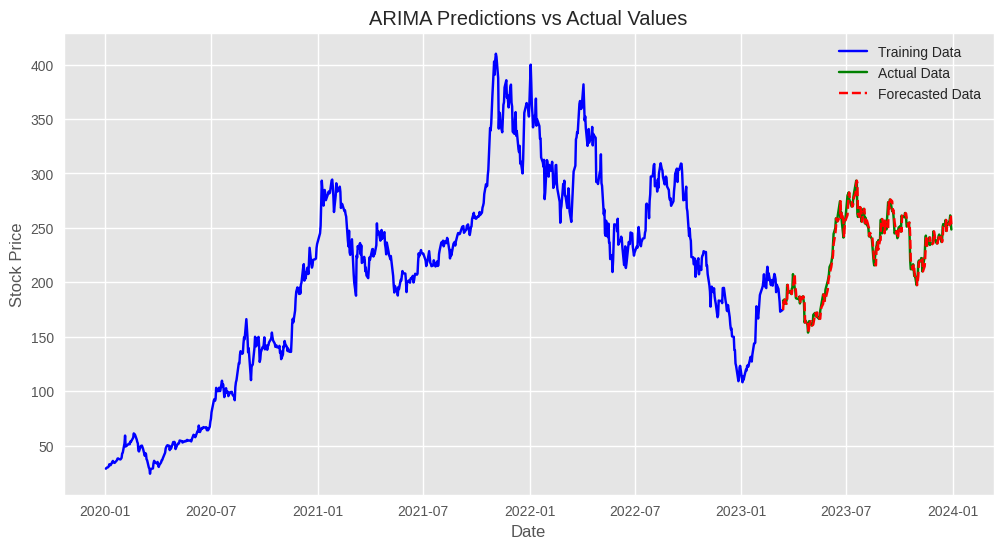

In [ ]:
arimal_model.plot_results()

#### ARIMAX (AutoRegressive Integrated Moving Average with eXogenous variables)

Explanation of exog_tickers
The exog_tickers parameter is a list of ticker symbols for exogenous variables. These are additional time series that are used as external regressors in the ARIMAX model. In the provided example, exog_tickers includes ['MSFT', 'GOOGL'], which means the closing prices of Microsoft (MSFT) and Google (GOOGL) stocks are used as exogenous variables to help predict the closing price of Apple (AAPL).

Plan for ARIMAX Model Analysis
To efficiently run the ARIMAX model analysis, we will break down the process into different cells. This will help avoid repeating prior steps and make the code more modular and easier to debug.

Import Libraries and Define the ARIMAXModel Class: This cell will include all necessary imports and the definition of the ARIMAXModel class.
Download Data: This cell will create an instance of the ARIMAXModel class and download the data.
Determine ARIMAX Order: This cell will determine the best ARIMAX model order using the auto_arima function.
Walk-Forward Validation: This cell will perform walk-forward validation, make predictions, and plot the results.


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import matplotlib.pyplot as plt

class ARIMAXModel:
    def __init__(self, ticker, start_date, end_date, exog_tickers):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.exog_tickers = exog_tickers
        self.model_order = (0, 1, 0)
        self.train = None
        self.test = None
        self.train_exog = None
        self.test_exog = None
        self.dataset_ex_df = None
        self.history = None
        self.history_exog = None
        self.predictions = []

    def download_data(self):
        # Download main ticker data
        gs = yf.download(self.ticker, start=self.start_date, end=self.end_date)
        self.dataset_ex_df = gs[['Close']].copy()
        self.dataset_ex_df.reset_index(inplace=True)
        self.dataset_ex_df['Date'] = pd.to_datetime(self.dataset_ex_df['Date'])
        self.dataset_ex_df.set_index('Date', inplace=True)

        # Download exogenous variables data
        for exog_ticker in self.exog_tickers:
            exog_data = yf.download(exog_ticker, start=self.start_date, end=self.end_date)
            self.dataset_ex_df[exog_ticker] = exog_data['Close']

        # Drop any rows with  values
        self.dataset_ex_df.dropna(inplace=True)

        print("Data downloaded and processed. Shape of the dataset:")
        print(self.dataset_ex_df.shape)
        print("\nFirst few rows of the dataset:")
        print(self.dataset_ex_df.head())

    def determine_arimax_order(self):
        endog = self.dataset_ex_df['Close']
        exog = self.dataset_ex_df[self.exog_tickers]

        model = auto_arima(endog, exogenous=exog, seasonal=False, trace=True, suppress_warnings=True)
        self.model_order = model.order
        print("\nBest ARIMAX model order:", self.model_order)
        print("\nModel summary:")
        print(model.summary())

    def arima_forecast(self, history, history_exog, exog):
        model = ARIMA(history, exog=history_exog, order=self.model_order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=1, exog=exog)
        return forecast[0]

    def walk_forward_validation(self, test_size=0.2):
        split_index = int(len(self.dataset_ex_df) * (1 - test_size))
        self.train = self.dataset_ex_df['Close'][:split_index]
        self.test = self.dataset_ex_df['Close'][split_index:]
        self.train_exog = self.dataset_ex_df[self.exog_tickers][:split_index]
        self.test_exog = self.dataset_ex_df[self.exog_tickers][split_index:]

        self.history = [x for x in self.train]
        self.history_exog = self.train_exog.values.tolist()

        for i in range(len(self.test)):
            exog = self.test_exog.iloc[i:i+1]
            yhat = self.arima_forecast(self.history, self.history_exog, exog)
            self.predictions.append(yhat)
            obs = self.test.iloc[i]
            self.history.append(obs)
            self.history_exog.append(exog.values.tolist()[0])
            print('Predicted: ' + str(yhat) + ', Expected: ' + str(obs))

        mse = np.mean((self.test - self.predictions) ** 2)
        rmse = np.sqrt(mse)
        print('Test RMSE: ' + str(rmse))

        plt.figure(figsize=(12, 6))
        plt.plot(self.test.index, self.test.values, label='Actual')
        plt.plot(self.test.index, self.predictions, label='Predicted')
        plt.title('ARIMAX Forecast for ' + self.ticker)
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.savefig('arimax_forecast.png')
        plt.close()

In [ ]:
arimax_model = ARIMAXModel('AAPL', '2020-01-01', '2023-07-31', ['MSFT', 'GOOGL'])

In [ ]:
arimax_model.download_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Data downloaded and processed. Shape of the dataset:
(899, 3)

First few rows of the dataset:
                Close        MSFT      GOOGL
Date                                        
2020-01-02  75.087502  160.619995  68.433998
2020-01-03  74.357498  158.619995  68.075996
2020-01-06  74.949997  159.029999  69.890503
2020-01-07  74.597504  157.580002  69.755501
2020-01-08  75.797501  160.089996  70.251999


In [ ]:
arimax_model.determine_arimax_order()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4331.143, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4327.678, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4326.638, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4326.422, Time=1.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4327.923, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4327.170, Time=1.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4327.436, Time=1.64 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4329.117, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4326.972, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 5.724 seconds

Best ARIMAX model order: (0, 1, 1)

Model summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  899
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2160.2

In [ ]:
arimax_model.walk_forward_validation()

print("ARIMAX model analysis completed.")

Predicted: 139.47135602765417, Expected: 139.5
Predicted: 137.58845697848338, Expected: 134.8699951171875
Predicted: 143.073287729551, Expected: 146.8699951171875
Predicted: 148.77247370055895, Expected: 149.6999969482422
Predicted: 147.52960022634667, Expected: 148.27999877929688
Predicted: 149.10193459248234, Expected: 150.0399932861328
Predicted: 150.02069902321728, Expected: 148.7899932861328
Predicted: 148.7019105931273, Expected: 150.72000122070312
Predicted: 150.2224389643278, Expected: 151.2899932861328
Predicted: 151.0562165809481, Expected: 148.00999450683594
Predicted: 149.57328775178865, Expected: 150.17999267578125
Predicted: 151.40904621512738, Expected: 151.07000732421875
Predicted: 150.79068622657408, Expected: 148.11000061035156
Predicted: 145.87897325875693, Expected: 144.22000122070312
Predicted: 143.5717913655037, Expected: 141.1699981689453
Predicted: 147.9647640568504, Expected: 148.02999877929688
Predicted: 147.87090721511953, Expected: 148.30999755859375
Predict

In [ ]:
def forecast_stock_prices(df, forecast_days=30):
    # Ensure 'Date' is set as the index and is in datetime format
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

    # Extract data from the last 1 month of the dataset
    df_last_month = df[df.index >= (df.index.max() - timedelta(days=30))]

    # Define the endogenous and exogenous variables
    y = df_last_month['Close']
    X = df_last_month[['Volume']]

    # Fit the ARIMAX model
    model_arimax = ARIMA(y, exog=X, order=(5, 1, 0))
    model_arimax_fit = model_arimax.fit()

    # Print the model summary
    print(model_arimax_fit.summary())

    # Generate dummy exogenous data for the forecast period
    exog_future = pd.DataFrame({'Volume': np.tile(X['Volume'].mean(), forecast_days)},
                               index=pd.date_range(start=df_last_month.index[-1] + pd.Timedelta(days=1),
                                                   periods=forecast_days))

    # Generate the forecast for the next 30 days with the corrected exogenous data
    forecast_arimax = model_arimax_fit.forecast(steps=forecast_days, exog=exog_future)
    forecast_dates_arimax = pd.date_range(start=df_last_month.index[-1], periods=forecast_days)
    forecast_df_arimax = pd.DataFrame({'Date': forecast_dates_arimax, 'Forecast': forecast_arimax})

    # Create the interactive plot using Plotly
    fig = go.Figure()

    # Add historical data
    fig.add_trace(go.Scatter(x=df_last_month.index, y=df_last_month['Close'],
                             mode='lines', name='Historical'))

    # Add forecast data
    fig.add_trace(go.Scatter(x=forecast_df_arimax['Date'], y=forecast_df_arimax['Forecast'],
                             mode='lines', name='Forecast', line=dict(color='red')))

    # Update layout
    fig.update_layout(
        title='Closing Price Forecast (ARIMAX)',
        xaxis_title='Date',
        yaxis_title='Closing Price',
        legend_title='Legend',
        hovermode='x unified'
    )

    # Add gridlines
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')

    # Show the interactive plot
    fig.show()

    return forecast_df_arimax

# Usage example:
# forecast = forecast_stock_prices(df)
forecast_stock_prices(df_tsla)

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   20
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 -76.126
Date:                Wed, 31 Jul 2024   AIC                            166.252
Time:                        04:25:39   BIC                            172.863
Sample:                             0   HQIC                           167.370
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Volume     -1.077e-07   4.73e-08     -2.276      0.023      -2e-07    -1.5e-08
ar.L1         -0.2062      0.255     -0.807      0.420      -0.707       0.295
ar.L2         -0.3747      0.205     -1.831      0.0

,Date,Forecast
20,2024-07-29,230.608338
21,2024-07-30,218.917475
22,2024-07-31,216.656788
23,2024-08-01,219.454479
24,2024-08-02,226.997302
25,2024-08-03,226.248106
26,2024-08-04,220.024014
27,2024-08-05,218.708649
28,2024-08-06,221.373442
29,2024-08-07,225.011581


#### ARIMAX

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3544
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -10570.079
Date:                Wed, 31 Jul 2024   AIC                          21152.159
Time:                        04:25:40   BIC                          21189.195
Sample:                             0   HQIC                         21165.368
                               - 3544                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0229      0.008     -2.727      0.006      -0.039      -0.006
ar.L2          0.0070      0.007      0.945      0.345      -0.008       0.022
ar.L3          0.0019      0.009      0.212      0.8

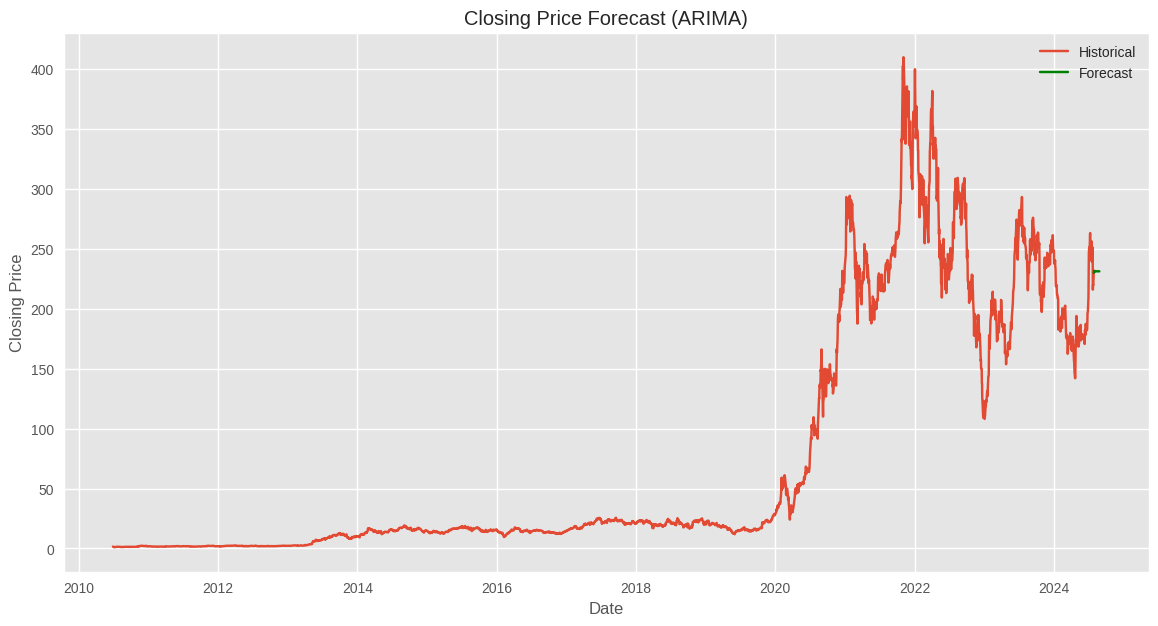

In [ ]:
# Define the endogenous variable
y = df_tsla['Close']

# Fit the ARIMA model
model_arima = ARIMA(y, order=(5, 1, 0))
model_arima_fit = model_arima.fit()

# Print the model summary
print(model_arima_fit.summary())

# Generate the forecast for the next 30 days
forecast_arima = model_arima_fit.forecast(steps=30)
forecast_dates_arima = pd.date_range(start=df_tsla.index[-1], periods=30)
forecast_df_arima = pd.DataFrame({'Date': forecast_dates_arima, 'Forecast': forecast_arima})

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_tsla['Close'], label='Historical')
plt.plot(forecast_df_arima['Date'], forecast_df_arima['Forecast'], label='Forecast', color='green')
plt.title('Closing Price Forecast (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

Best ARIMA model order: (2, 1, 2)
RMSE for in-sample predictions: 2.53
RMSE for out-of-sample forecast: 64.10


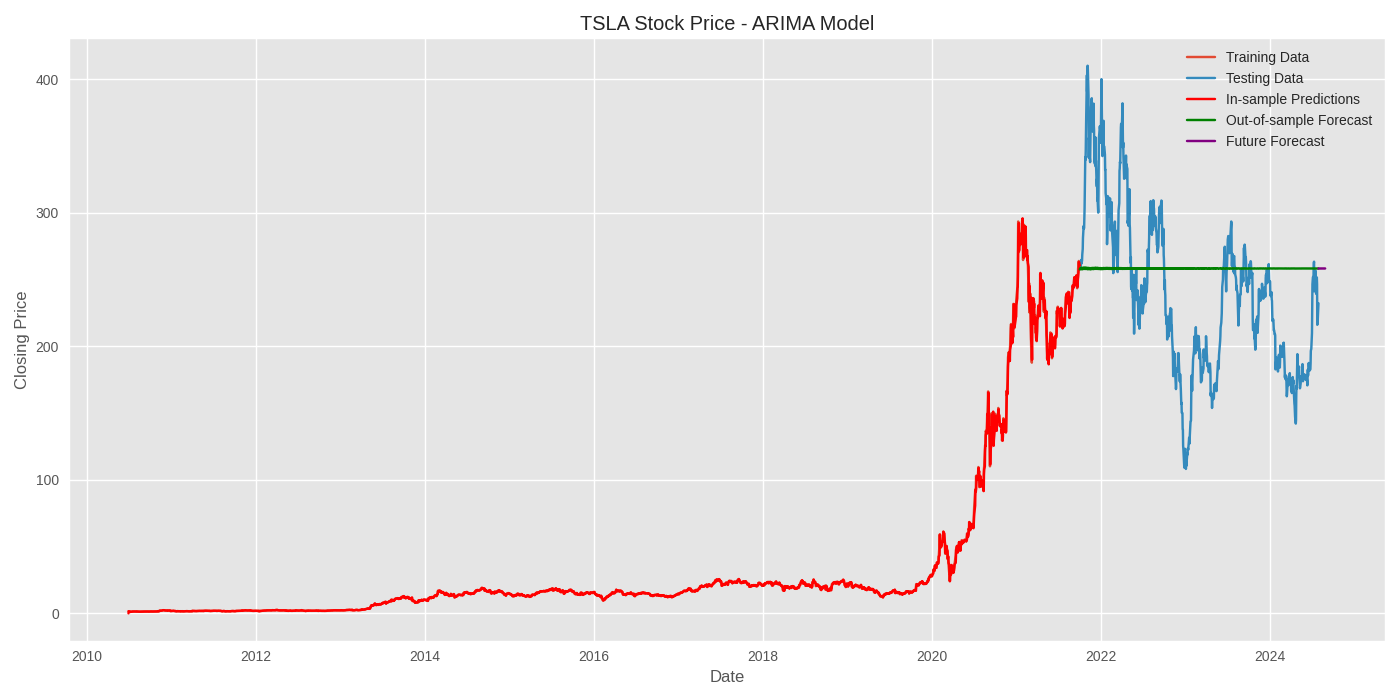

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# Define the endogenous variable
y = df_tsla['Close']

# Split the data into training and testing sets
train_size = int(len(y) * 0.8)
train, test = y[:train_size], y[train_size:]

# Define the p, d, and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, d and q triplets
pdq = list(product(p, d, q))

# Run a grid search with the specified parameters
best_aic = np.inf
best_pdq = None
best_model = None

for param in pdq:
    try:
        model = ARIMA(train, order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_model = results
    except:
        continue

print(f"Best ARIMA model order: {best_pdq}")

# Fit the best model
model_arima = ARIMA(train, order=best_pdq)
model_arima_fit = model_arima.fit()

# Generate in-sample predictions
in_sample_pred = model_arima_fit.predict(start=0, end=len(train)-1)

# Generate out-of-sample forecast
forecast_steps = len(test)
forecast = model_arima_fit.forecast(steps=forecast_steps)

# Generate future forecast (next 30 days after the test set)
future_forecast = model_arima_fit.forecast(steps=forecast_steps+30)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Testing Data')
plt.plot(train.index, in_sample_pred, label='In-sample Predictions', color='red')
plt.plot(test.index, forecast, label='Out-of-sample Forecast', color='green')
plt.plot(pd.date_range(start=test.index[-1], periods=30), future_forecast[-30:], label='Future Forecast', color='purple')
plt.title('TSLA Stock Price - ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('tsla_arima_forecast.png')
plt.close()

# Calculate RMSE for in-sample predictions and out-of-sample forecast
rmse_in_sample = np.sqrt(mean_squared_error(train, in_sample_pred))
rmse_out_sample = np.sqrt(mean_squared_error(test, forecast))

print(f"RMSE for in-sample predictions: {rmse_in_sample:.2f}")
print(f"RMSE for out-of-sample forecast: {rmse_out_sample:.2f}")

# Display the plot
from IPython.display import Image
Image('tsla_arima_forecast.png')

#### ARIMA-GARCH

# Exponential Smoothing Model (ETS)

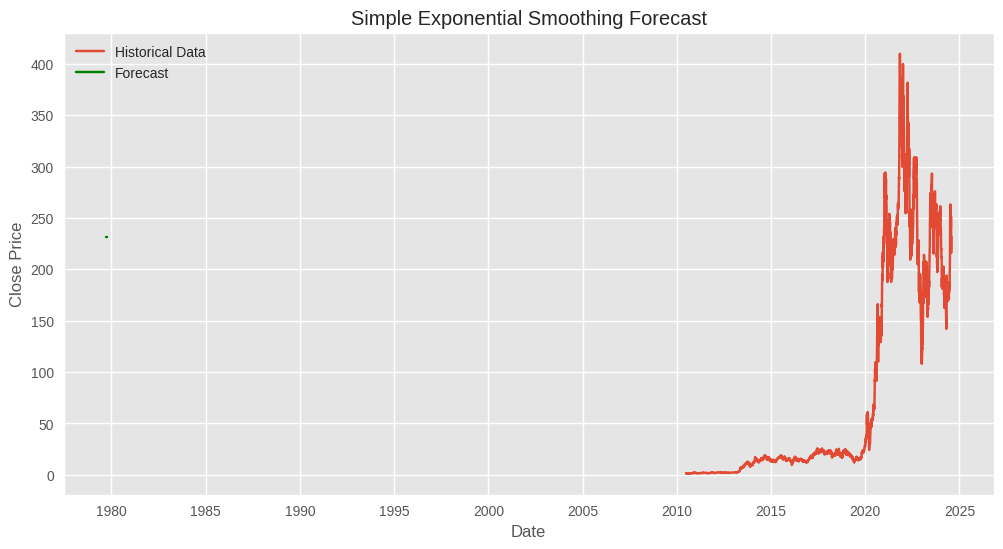

3544    231.815912
3545    231.815912
3546    231.815912
3547    231.815912
3548    231.815912
3549    231.815912
3550    231.815912
3551    231.815912
3552    231.815912
3553    231.815912
3554    231.815912
3555    231.815912
3556    231.815912
3557    231.815912
3558    231.815912
3559    231.815912
3560    231.815912
3561    231.815912
3562    231.815912
3563    231.815912
3564    231.815912
3565    231.815912
3566    231.815912
3567    231.815912
3568    231.815912
3569    231.815912
3570    231.815912
3571    231.815912
3572    231.815912
3573    231.815912
dtype: float64


In [ ]:
# Can you explain the key characteristics of the Simple Exponential Smoothing model?
# What are the limitations of using Simple Exponential Smoothing for forecasting?

# Fit a Simple Exponential Smoothing model to the 'Close' column
ses_model = SimpleExpSmoothing(df_tsla['Close']).fit()

# Generate a forecast for the next 30 periods
forecast_steps = 30
forecast = ses_model.forecast(steps=forecast_steps)

# Plot the historical data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(df_tsla['Close'], label='Historical Data')
plt.plot(forecast, label='Forecast', color='green')
plt.title('Simple Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Print the forecast values
print(forecast)

In [ ]:
# #!/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on Mon Nov 25 16:48:15 2019

# @author: nageshsinghchauhan
# """




# # dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
# dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')
# data = pd.read_csv('./TSLA.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

# #plot close price
# plt.figure(figsize=(10,6))
# plt.grid(True)
# plt.xlabel('Dates')
# plt.ylabel('Close Prices')
# plt.plot(data['Close'])
# plt.title('Altaba Inc. closing price')
# plt.show()

# #scatter plot of the sales
# df_close = data['Close']
# df_close.plot(style='k.')
# plt.title('Scatter plot of closing price')
# plt.show()

# #Distribution of the dataset
# df_close.plot(kind='kde')
# #We can observe a near-normal distribution(bell-curve) over sales values.

# #Test for staionarity
# def test_stationarity(timeseries):
#     #Determing rolling statistics
#     rolmean = timeseries.rolling(12).mean()
#     rolstd = timeseries.rolling(12).std()
#     #Plot rolling statistics:
#     plt.plot(timeseries, color='blue',label='Original')
#     plt.plot(rolmean, color='red', label='Rolling Mean')
#     plt.plot(rolstd, color='black', label = 'Rolling Std')
#     plt.legend(loc='best')
#     plt.title('Rolling Mean and Standard Deviation')
#     plt.show(block=False)

#     print("Results of dickey fuller test")
#     adft = adfuller(timeseries,autolag='AIC')
#     # output for dft will give us without defining what the values are.
#     #hence we manually write what values does it explains using a for loop
#     output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
#     for key,values in adft[4].items():
#         output['critical value (%s)'%key] =  values
#     print(output)

# test_stationarity(df_close)

# #To separate the trend and the seasonality from a time series,
# # we can decompose the series using the following code.
# # result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
# result = seasonal_decompose(df_close, model='multiplicative', period=30)
# fig = plt.figure()
# fig = result.plot()
# fig.set_size_inches(16, 9)


# #if not stationary then eliminate trend
# #Eliminate trend
# from pylab import rcParams
# rcParams['figure.figsize'] = 10, 6
# df_log = np.log(df_close)
# moving_avg = df_log.rolling(12).mean()
# std_dev = df_log.rolling(12).std()
# plt.legend(loc='best')
# plt.title('Moving Average')
# plt.plot(std_dev, color ="black", label = "Standard Deviation")
# plt.plot(moving_avg, color="red", label = "Mean")
# plt.legend()
# plt.show()


# #split data into train and training set
# train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
# plt.figure(figsize=(10,6))
# plt.grid(True)
# plt.xlabel('Dates')
# plt.ylabel('Closing Prices')
# plt.plot(df_log, 'green', label='Train data')
# plt.plot(test_data, 'blue', label='Test data')
# plt.legend()

# #Modeling

# # Build Model
# # model = ARIMA(train_data, order=(3, 1, 2))
# # fitted = model.fit(disp=-1)

# model = ARIMA(train_data, order=(3, 1, 2))
# fitted = model.fit()

# print(fitted.summary())



# # Forecast
# # fc, se, conf = fitted.forecast(544, alpha=0.05)  # 95% conf
# # Forecast
# forecast_results = fitted.get_forecast(steps=544)
# fc = forecast_results.predicted_mean
# se = forecast_results.se_mean
# conf = forecast_results.conf_int(alpha=0.05)

# # Make as pandas series
# fc_series = pd.Series(fc, index=test_data.index)
# lower_series = pd.Series(conf[:, 0], index=test_data.index)
# upper_series = pd.Series(conf[:, 1], index=test_data.index)
# # Plot
# plt.figure(figsize=(10,5), dpi=100)
# plt.plot(train_data, label='training')
# plt.plot(test_data, color = 'blue', label='Actual Stock Price')
# plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
# plt.fill_between(lower_series.index, lower_series, upper_series,
#                  color='k', alpha=.10)
# plt.title('Altaba Inc. Stock Price Prediction')
# plt.xlabel('Time')
# plt.ylabel('Altaba Inc. Stock Price')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()


# # report performance
# mse = mean_squared_error(test_data, fc)
# print('MSE: '+str(mse))
# mae = mean_absolute_error(test_data, fc)
# print('MAE: '+str(mae))
# rmse = math.sqrt(mean_squared_error(test_data, fc))
# print('RMSE: '+str(rmse))
# mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
# print('MAPE: '+str(mape))
# #Around 3.5% MAPE implies the model is about 96.5% accurate in predicting the next 15 observations.


# """
# Auto arima gives the value of p,q,d as 3,1,2
# model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
#                       test='adf',       # use adftest to find optimal 'd'
#                       max_p=3, max_q=3, # maximum p and q
#                       m=1,              # frequency of series
#                       d=None,           # let model determine 'd'
#                       seasonal=False,   # No Seasonality
#                       start_P=0,
#                       D=0,
#                       trace=True,
#                       error_action='ignore',
#                       suppress_warnings=True,
#                       stepwise=True)

# print(model_autoARIMA.summary())
# model_autoARIMA.plot_diagnostics(figsize=(15,8))
# plt.show()
# """

# Long Short-Term Memory (LSTM)

In [ ]:
# stock_name = 'TSLA'
# data = yf.download(stock_name, start="2020-03-26", end="2021-03-29")

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM

def lstm(stock_name, data):
    # Choose only Close price of stock
    data = data.filter(['Close'])
    dataset = data.values
    # Train data - 80%, test - 20%
    training_data_len = int(np.ceil( len(dataset) * .80 ))

    # Scale our data from 0 to 1
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)

    # Use our scaled data for training
    train_data = scaled_data[0:int(training_data_len), :]
    x_train = []
    y_train = []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
        if i<= 61:
            print(x_train)
            print(y_train)
            print()

    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape = (x_train.shape[1], 1)))
    model.add(Dropout(0.35))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(25, activation = 'relu'))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

    # Тrain the model
    model.fit(x_train, y_train, batch_size=1, epochs=2)

    # Structure of the model
    keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

    # Create test dataset
    test_data = scaled_data[training_data_len - 60: , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])

    x_test = np.array(x_test)

    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    # Predict on test data
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # For finding error we use RMSE formula, but MSE can be used too
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    print(f'RMSE LSTM: {rmse}')

    # Graphs
    train = data[:training_data_len]
    valid = data[training_data_len:]
    train_gr = train['Close'].values
    valid_gr = valid['Close'].values



    preds_gr = np.reshape(predictions, (50,))

    x_train = list(range(0, len(train_data)))
    x_valid = list(range(len(train_data)-1, len(dataset)))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x_train, y=train_gr, mode='lines+markers', marker=dict(size=4),  name='train', marker_color='#39304A'))
    fig.add_trace(go.Scatter(x=x_valid, y=valid_gr, mode='lines+markers', marker=dict(size=4), name='valid', marker_color='#A98D75'))
    fig.add_trace(go.Scatter(x=x_valid, y=preds_gr, mode='lines+markers', marker=dict(size=4), name='predictions', marker_color='#FFAA00'))
    fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'{stock_name} LSTM data', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
    fig.show()

    # Predict stock prices for next moth
    data_new = yf.download(stock_name, start="2021-03-01", end="2021-04-30")

    data_new = data_new.filter(['Close'])
    dataset = data_new.values
    training_data_len = len(dataset)

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)

    test_data = scaled_data[training_data_len - len(data_new): , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(20, len(test_data)):
        x_test.append(test_data[i-20:i, 0])

    x_test = np.array(x_test)

    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    hist_data_new = yf.download(stock_name, start="2021-04-01", end="2021-05-04")
    hist_data_new = hist_data_new.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
    hist_data_new = hist_data_new['Close']
    hist_data_new = np.array(hist_data_new)
    pred_lstm = model.predict(x_test)
    pred_lstm = pred_lstm[:-1]
    pred_lstm = scaler.inverse_transform(pred_lstm)


    # build graphs
    preds_gr = np.reshape(pred_lstm, (22,))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(0, 21)), y=hist_data_new, mode='lines+markers',  name='historical', marker_color='#39304A'))
    fig.add_trace(go.Scatter(x=list(range(0, 21)), y=preds_gr, mode='lines+markers', name='predictions', marker_color='#FFAA00'))
    fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'{stock_name} LSTM prediction', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
    fig.show()

    return pred_lstm, rmse

In [ ]:
# getting data from Yahoo Finance
stock_name = 'TSLA'  # here you can change the name of stock ticker, for example we will take AMD ticker
data_tsla = yf.download(stock_name, start="2020-03-26", end="2021-03-29")


lstm_pred, lstm_rmse = lstm(stock_name, data_tsla)

[*********************100%%**********************]  1 of 1 completed


[array([0.01860398, 0.01512   , 0.01203238, 0.01755374, 0.00683922,
       0.        , 0.0064479 , 0.01559463, 0.02296907, 0.02382491,
       0.02992441, 0.04960389, 0.06448404, 0.06951815, 0.07340103,
       0.0755924 , 0.07369135, 0.05863448, 0.07009377, 0.06340855,
       0.06833662, 0.08691788, 0.0794374 , 0.08736221, 0.08265883,
       0.06232043, 0.07743537, 0.07920767, 0.08283556, 0.0821943 ,
       0.09213628, 0.09008376, 0.08960913, 0.0849512 , 0.08807415,
       0.08702391, 0.09067453, 0.08925568, 0.09116178, 0.09420143,
       0.09149503, 0.09199742, 0.09234078, 0.08870028, 0.09606966,
       0.11200005, 0.10782433, 0.10817776, 0.10348701, 0.10885941,
       0.12508267, 0.1227474 , 0.14405022, 0.13086913, 0.12138663,
       0.13542859, 0.13321451, 0.13565328, 0.13872575, 0.13795324])]
[0.1362920306495754]

[array([0.01860398, 0.01512   , 0.01203238, 0.01755374, 0.00683922,
       0.        , 0.0064479 , 0.01559463, 0.02296907, 0.02382491,
       0.02992441, 0.04960389, 0.064

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 2s 2s/step


### ARIMA-LSTM Hybrid Model

In [ ]:
# Function to create ARIMA component
def arima_component(data, order=(1,1,1)):
    model = ARIMA(data, order=order)
    results = model.fit()
    return results.forecast(steps=len(data))

# Function to create a simple neural network to simulate LSTM component
def simple_nn_component(data, window_size=20, epochs=100, learning_rate=0.01):
    np.random.seed(42)
    weights = np.random.randn(window_size, 1)
    bias = np.random.randn(1, 1)

    for epoch in range(epochs):
        for i in range(window_size, len(data)):
            x = data[i-window_size:i]
            y = data[i]
            y_pred = np.dot(x.T, weights) + bias
            error = y - y_pred
            weights += learning_rate * error * x
            bias += learning_rate * error

    predictions = []
    for i in range(window_size, len(data)):
        x = data[i-window_size:i]
        y_pred = np.dot(x.T, weights) + bias
        predictions.append(y_pred)

    return np.array(predictions).flatten()

# Function to create hybrid ARIMA-LSTM model
def arimalstm(stock_name, start_date, end_date, window_size=20, epochs=2, learning_rate=0.01):
    # Download the stock data
    data = yf.download(stock_name, start=start_date, end=end_date)
    close_prices = data['Close'].values.reshape(-1, 1)

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(close_prices)

    # ARIMA component
    arima_predictions = arima_component(close_prices)

    # LSTM component (simulated with simple neural network)
    nn_predictions = simple_nn_component(scaled_data, window_size, epochs, learning_rate)
    nn_predictions = scaler.inverse_transform(nn_predictions.reshape(-1, 1)).flatten()

    # Combine ARIMA and LSTM predictions
    hybrid_predictions = 0.5 * arima_predictions[window_size:] + 0.5 * nn_predictions

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(close_prices[window_size:], hybrid_predictions))

    return data.index, close_prices, hybrid_predictions, rmse

[*********************100%%**********************]  1 of 1 completed


RMSE: 239.4340371913856


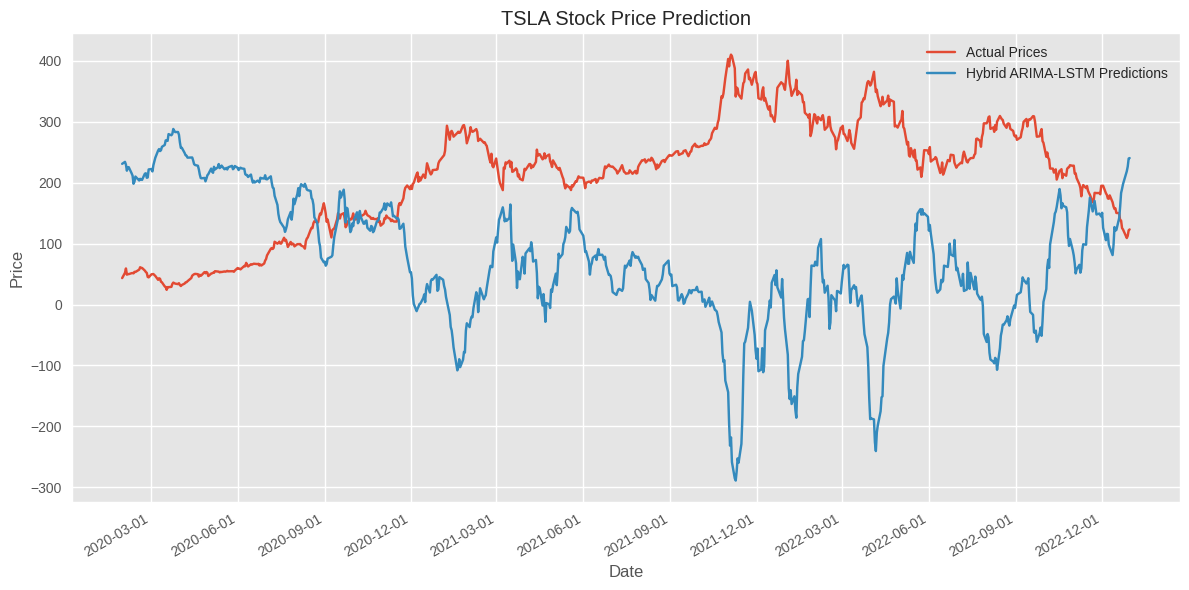

Chart generated successfully.


In [ ]:
# Test the function
start_date = '2020-01-01'
end_date = '2023-01-01'

dates, actual_prices, hybrid_predictions, rmse = arimalstm(TICKER, start_date, end_date)

print(f"RMSE: {rmse}")

# Plot the results
plt.figure(figsize=(12,6))
plt.plot(dates[20:], actual_prices[20:], label='Actual Prices')
plt.plot(dates[20:], hybrid_predictions, label='Hybrid ARIMA-LSTM Predictions')
plt.title(f'{TICKER} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Format x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()  # Rotation

plt.tight_layout()
plt.show()

print("Chart generated successfully.")